In [1]:
# ## Enviroment Setup
# import os, sys
# WORKING_DIR = '/home/peizhi/Documents/gmesh'
# os.chdir(WORKING_DIR) # change the working directory to the project's absolute path
# print("Current Working Directory: ", os.getcwd())

## Computing Device
device = 'cuda:0'
import torch
torch.cuda.set_device(device) # this will solve the problem that OpenGL not on the same device with torch tensors

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

import gmesh.utils.o3d_utils as o3d_utils
from gmesh.utils.mesh2gaussians_utils import mesh_to_gaussians
from gmesh.scenes.mesh import Mesh
from gmesh.scenes.gaussians import Gaussians
from gmesh.scenes.cameras import PerspectiveCamera, OrbitCamera
from gmesh.renderer.gmesh_renderer import GmeshRenderer
from gmesh.renderer.shader import simple_phone_shading
from gmesh.utils.vis_utils import visualize_rgbd_alpha



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Creat the Scene

In [2]:

# load an example mesh
vertices, faces = o3d_utils._read_obj_file('../assets/data/spot.obj', uv=False)

# rotate the mesh along the y axis (yaw)
theta = np.pi * 0.8
rotation_matrix = torch.tensor([
    [np.cos(theta), 0, np.sin(theta)],
    [0, 1, 0],
    [-np.sin(theta), 0, np.cos(theta)]
], dtype=torch.float32, device=device)

# convert from numpy arrays to tensors
vertices = torch.from_numpy(vertices).float().to(device) @ rotation_matrix.T  # [V, 3]
faces = torch.from_numpy(faces).to(device) # [F, 3]

# create to Mesh object
mesh = Mesh(verts=vertices, faces=faces)

# shading for visualizing mesh 
mesh.colors = simple_phone_shading(vertices=vertices, faces=faces)

# create Gaussians from the Mesh
gaussians = mesh_to_gaussians(mesh=mesh, method='facet3', trainable=False)

# make the Gaussians colors more red
gaussians.colors[:,:,0] = 1.0
gaussians.colors[:,:,1] = 1.0
gaussians.colors[:,:,2] = 0.2

# create the camera
camera = PerspectiveCamera(
    image_width=1024, image_height=512, fov_x=40, fov_y=20, z_near=0.1, z_far=100, device=device
)

# set camera pose (yaw, pitch, roll, dx, dy, dz)
camera_pose = torch.tensor([[0,0,0,0,0,7.0]]).float().to(device)

"""
## Alternatively, you can use OrbitCamera

# create the camera
camera = OrbitCamera(
    image_width=1024, image_height=512, fov_x=40, fov_y=20, z_near=0.1, z_far=100, device=device
)

# set orbit camera pose (elevation, azimuth, distance)
camera_pose = torch.tensor([[0,0,7]]).float().to(device)
"""

print(mesh)
print(gaussians)

Mesh(Vertices=2930, Faces=5856)
Gaussians(N=17568, SH Degrees=0, means=torch.Size([17568, 3]), quats=torch.Size([17568, 4]), scales=torch.Size([17568, 3]), opacities=torch.Size([17568]), colors=torch.Size([17568, 1, 3]))


### Create the Gmesh Renderer

In [3]:
gmesh_renderer = GmeshRenderer(camera=camera, tile_size=16, bg_color=(.0,.0,.0))


### Render Both Mesh and Gaussians

Rendered Mesh


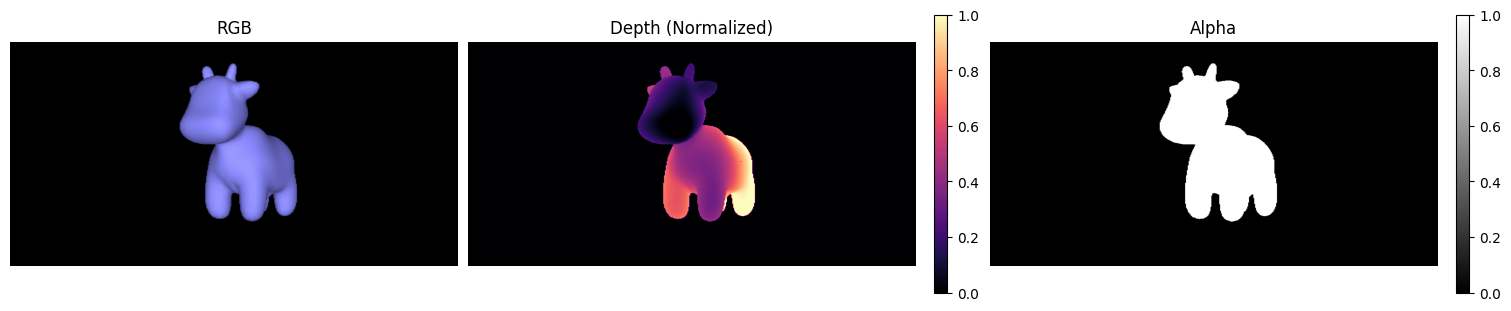

Rendered 3D Gaussians


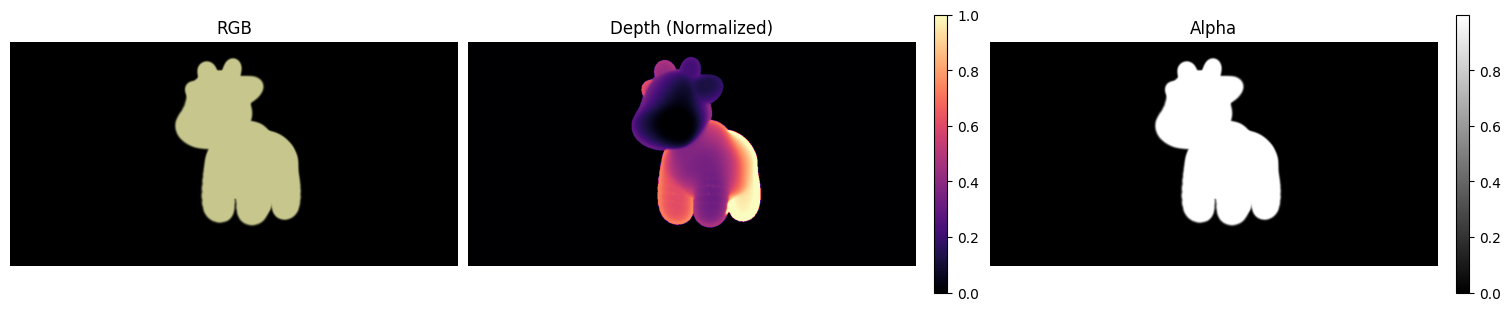

Blended Results


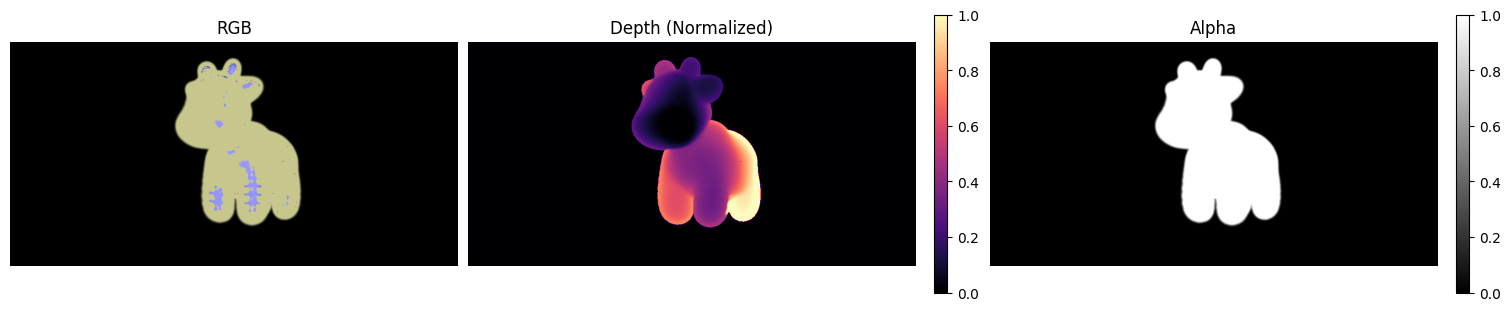

In [4]:
# render the 3D mesh
ret_dict = gmesh_renderer.render(mesh=mesh, gaussians=gaussians, camera_pose=camera_pose, return_all=True)

print('Rendered Mesh')
[rgb, depth, alpha] = ret_dict['mesh']
visualize_rgbd_alpha(rgb, depth, alpha, norm_depth=True)

print('Rendered 3D Gaussians')
[rgb, depth, alpha] = ret_dict['3dgs']
visualize_rgbd_alpha(rgb, depth, alpha, norm_depth=True)

print('Blended Results')
[rgb, depth, alpha] = ret_dict['blend']
visualize_rgbd_alpha(rgb, depth, alpha, norm_depth=True)
